# Feature engineering, pipelines, tuning, autoML

## Agenda

- Introduction to time series transformers (in sklearn sense)
- Combining transformers for feature engineering with pipelines (composition)
- Parameter tuning and autoML


In [1]:
import warnings
warnings.filterwarnings("ignore")

## Why time series transformers?

Tranformers in `sktime` referr to a catch-all term that encompses modular data processing steps.

We use this term in the `sklearn` sense, so this is unrelated to transformers in NLP or deep learning.

### Manual tranformations: doing things the wrong way

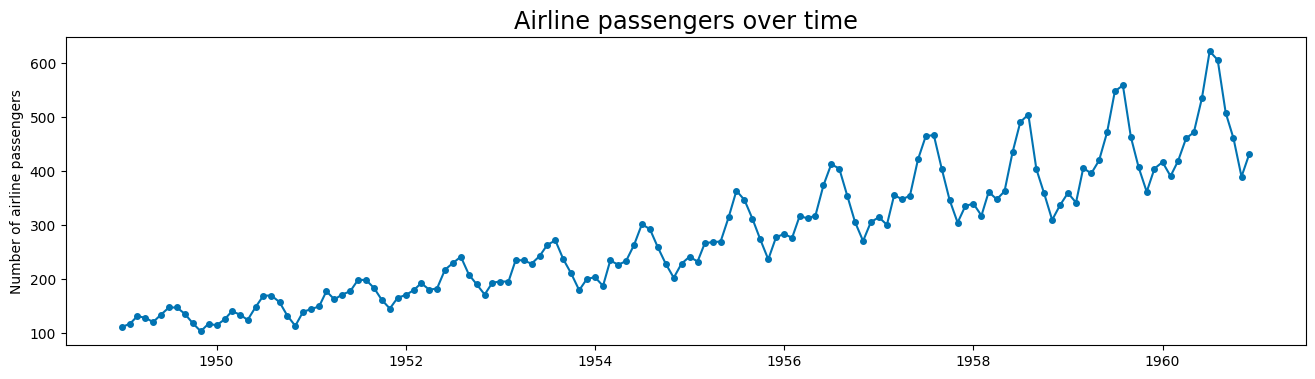

In [2]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y, title="Airline passengers over time")

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

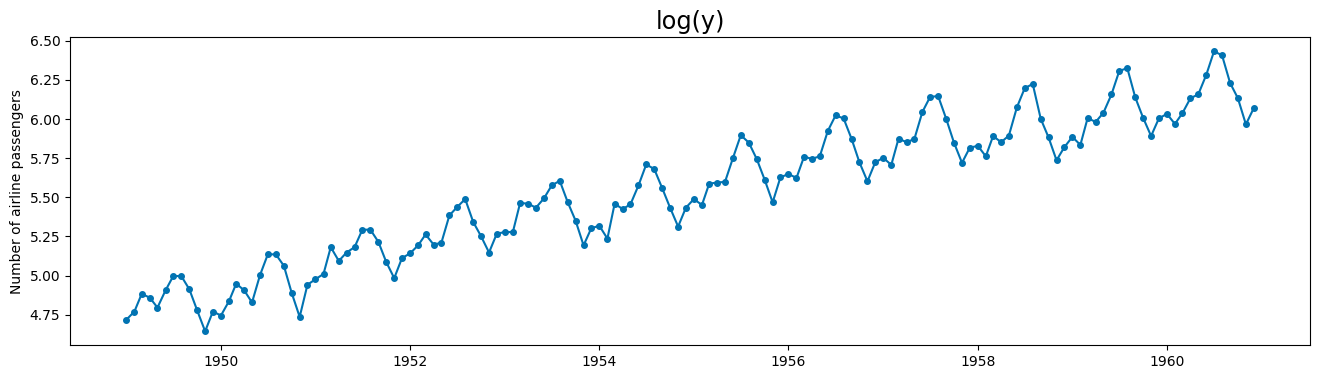

In [3]:
import numpy as np

y_log = np.log(y)

fig, ax = plot_series(y_log, title="log(y)")

this looks additive now!

next: remove seasonality

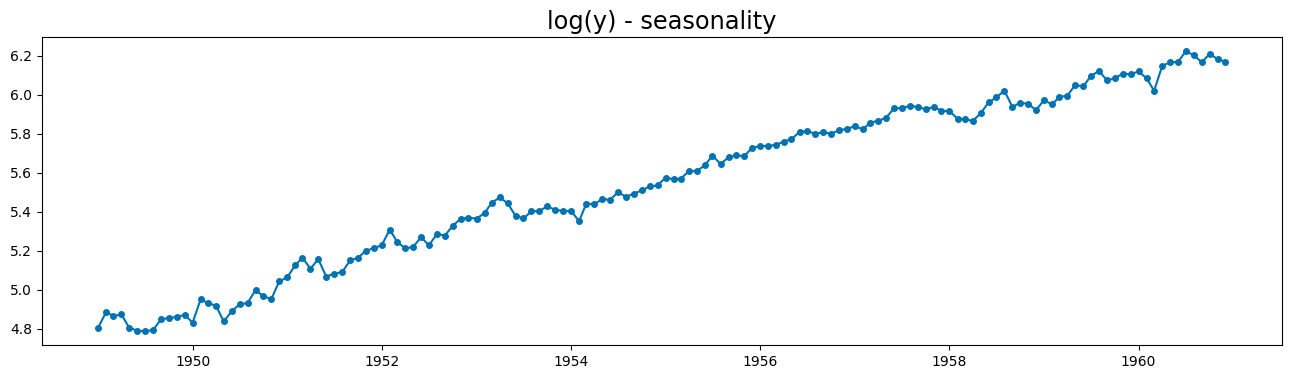

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

fig, ax = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

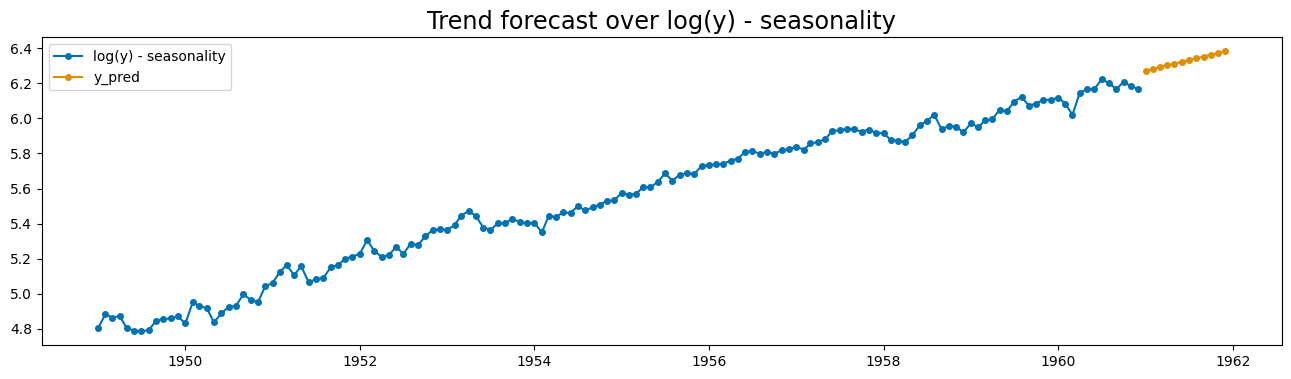

In [5]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Alternatively: list(range(1, 13))
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

Looks reasonable! Now back to original domain:

* add back seasonal component
* invert logarithm (exponentiate)

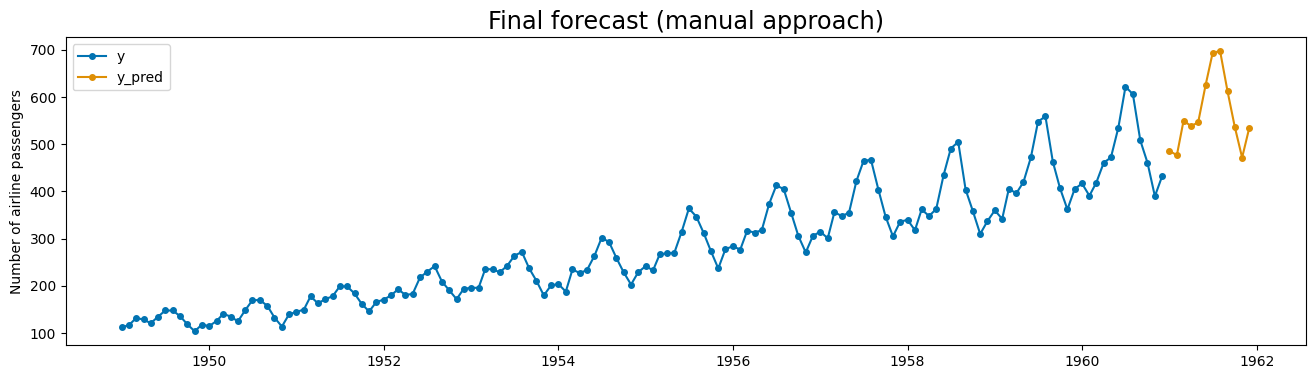

In [6]:
y_pred_add_seasonality = y_pred + seasonal[0:12].values
y_pred_orig = np.exp(y_pred_add_seasonality)

fig, ax = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

Ok, done! But it was tedious!

Is there a better way?

### `sktime` transformers: doing things the right way

Solution: use transformers & pipelines!

Same interface at every step! Easily composable!

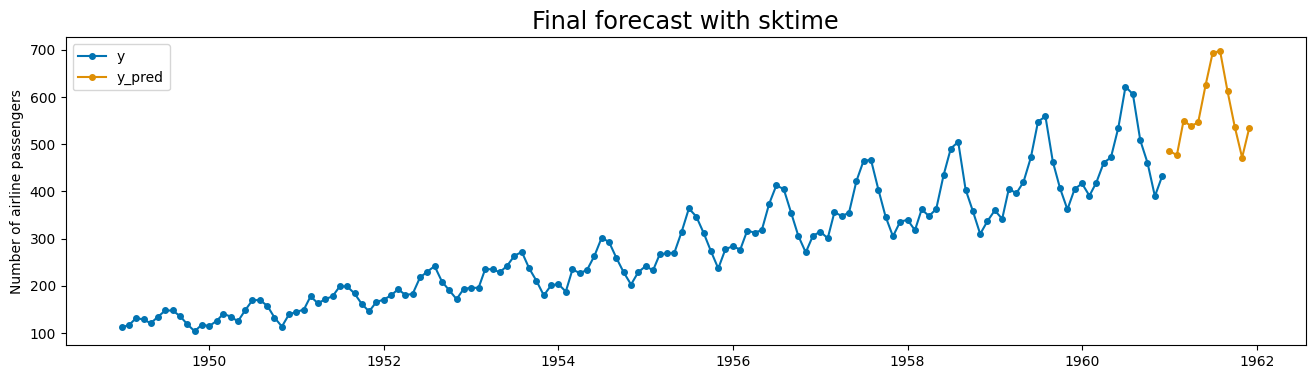

In [7]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

fh = list(range(1, 13))
y_pred = forecaster.fit_predict(y, fh=fh)

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [8]:
forecaster

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## Transformer types in `sktime`

Common types of transformation in `sktime`:

| from | to | base class | examples (sci) | examples (`sktime`) |
| --- | --- | --- | --- | --- |
| time series | scalar features | `BaseTransformer` (`Primitives` output) | `tsfresh`, or 7-number-summary | `Catch22`,`SummaryTransformer` |
| time series | time series | `BaseTransformer` (`Series`, `instancewise`)  | detrending, smoothing, filtering, lagging | `Detrender`,`Differencer`, `Lag`, `Filter` |
| time series panel | also a panel | `BaseTransformer` (`Series` output)  | principal component projection | `PCATransformer`,`PaddingTransformer` |
| two feature vectors | a scalar | `BasePairwiseTransformer` | Euclidean distance, L1 distance | `ScipyDist`, `AggrDist`, `FlatDist` |
| two time series | a scalar | `BasePairwiseTransformerPanel` | DTW distance, alignment kernel | `DtwDist`, `EditDist` |

To illustrate the difference, we compare two transformers with different output:

- The Box-Cox transformer `BoxCoxTransformer`, which transforms a time series to a time series
- The summary transformer `SummaryTransformer`, which transforms a time series to descriptive scalars (e.g. mean, standard deviation, etc.)

In [9]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer

y = load_airline()

boxcox = BoxCoxTransformer()
summary = SummaryTransformer()

In [10]:
# BoxCoxTransformer() produces a pd.Series
boxcox.fit_transform(y)

Period
1949-01     6.827490
1949-02     6.932822
1949-03     7.161892
1949-04     7.114611
1949-05     6.983787
             ...    
1960-08    10.684049
1960-09    10.234573
1960-10     9.992159
1960-11     9.582623
1960-12     9.831860
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [11]:
# SummaryTransformer() produces a (set of) scalar (values)
summary.fit_transform(y)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,280.298611,119.966317,104.0,622.0,135.3,180.0,265.5,360.5,453.2


In [12]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
    suppress_import_stdout=False,
)

,name,object
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BKFilter,<class 'sktime.transformations.series.bkfilter...
3,Bollinger,<class 'sktime.transformations.series.bollinge...
4,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
...,...,...
95,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
96,VmdTransformer,<class 'sktime.transformations.series.vmd.VmdT...
97,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
98,WindowSummarizer,<class 'sktime.transformations.series.summariz...


### Transformer broadcasting

Like forecasters, transformers are automatically broadcast to rows and/or columns depending on the setting:

* Column broadcasting: if data is multivariate and transform assumes univariate data.
* Row broadcasting: if data is panel or hierarchical and transform assumes single time series.

In [13]:
from sktime.datasets import load_hierarchical_sales_toydata

y_hier = load_hierarchical_sales_toydata()

y_hier

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

In [14]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

boxcox = BoxCoxTransformer(method="mle")
boxcox.fit_transform(y_hier)

Sales
Product line      Product group Date               
Food preparation  Hobs          2000-01  114.062785
                                2000-02   72.996366
                                2000-03   89.711987
                                2000-04  121.808863
                                2000-05  110.542080
...                                             ...
Food preservation Fridges       2004-08   75.360208
                                2004-09   85.233845
                                2004-10   30.886664
                                2004-11   66.577140
                                2004-12   74.320482

[240 rows x 1 columns]

In [15]:
boxcox.transformers_

transformers
Food preparation  Hobs      BoxCoxTransformer()
                  Ovens     BoxCoxTransformer()
Food preservation Freezers  BoxCoxTransformer()
                  Fridges   BoxCoxTransformer()

## Combining transformers, feature engineering

transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### Chaining transformers via `*`

In [16]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import SummaryTransformer

pipe = Differencer() * SummaryTransformer()

# this constructs a TransformerPipeline, which is also a transformer
pipe

TransformerPipeline(steps=[Differencer(), SummaryTransformer()])

In [17]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# this is a transformer with the same interface
# first applies differencer, then summary transform
pipe.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.222222,33.636569,-101.000000,87.000000,-37.700000,-16.000000,3.500000,22.250000,43.000000
1,36.957011,564.334952,-1702.744922,1477.441478,-627.898192,-266.419668,58.265167,368.648006,723.588749


compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [18]:
from sklearn.preprocessing import StandardScaler

pipe = Differencer() * StandardScaler()

pipe

TransformerPipeline(steps=[Differencer(),
                           TabularToSeriesAdaptor(transformer=StandardScaler())])

In [19]:
pipe.fit_transform(X)

passengers
l1_agg    timepoints            
l1_node01 1949-01      -0.066296
          1949-02       0.112704
          1949-03       0.351370
          1949-04      -0.155796
          1949-05      -0.304963
...                          ...
l1_node02 1960-08      -0.549810
          1960-09      -3.021493
          1960-10      -1.477325
          1960-11      -2.190264
          1960-12       1.189880

[288 rows x 1 columns]

pipeline-adaptor chains can be constructed manually:

* `sktime.transformations.compose.TransformerPipeline`
* `sktime.transformations.series.adapt.TabularToSeriesAdaptor` for `sklearn`

composites are compatible with `get_params` / `set_params` parameter interface:

In [20]:
pipe.get_params()

{'steps': [Differencer(),
  TabularToSeriesAdaptor(transformer=StandardScaler())],
 'Differencer': Differencer(),
 'TabularToSeriesAdaptor': TabularToSeriesAdaptor(transformer=StandardScaler()),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'TabularToSeriesAdaptor__fit_in_transform': False,
 'TabularToSeriesAdaptor__input_type': 'numpy',
 'TabularToSeriesAdaptor__pass_y': 'auto',
 'TabularToSeriesAdaptor__pooling': 'local',
 'TabularToSeriesAdaptor__transformer': StandardScaler(),
 'TabularToSeriesAdaptor__transformer__copy': True,
 'TabularToSeriesAdaptor__transformer__with_mean': True,
 'TabularToSeriesAdaptor__transformer__with_std': True}

### Feature union via `+`

In [21]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag()

# this constructs a FeatureUnion, which is also a transformer
pipe

FeatureUnion(transformer_list=[Differencer(), Lag()])

In [22]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

Differencer__passengers  Lag__lag_0__passengers
l1_agg    timepoints                                                 
l1_node01 1949-01                        0.00                  112.00
          1949-02                        6.00                  118.00
          1949-03                       14.00                  132.00
          1949-04                       -3.00                  129.00
          1949-05                       -8.00                  121.00
...                                       ...                     ...
l1_node02 1960-08                     -250.40                 9500.26
          1960-09                    -1533.70                 7966.56
          1960-10                     -735.55                 7231.01
          1960-11                    -1111.15                 6119.86
          1960-12                      657.30                 6777.16

[288 rows x 2 columns]

to retain the original columns, use the `Id` transformer:

In [23]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01             112.00                     0.00   
          1949-02             118.00                     6.00   
          1949-03             132.00                    14.00   
          1949-04             129.00                    -3.00   
          1949-05             121.00                    -8.00   
...                              ...                      ...   
l1_node02 1960-08            9500.26                  -250.40   
          1960-09            7966.56                 -1533.70   
          1960-10            7231.01                  -735.55   
          1960-11            6119.86                 -1111.15   
          1960-12            6777.16                   657.30   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  
l1_agg    timepoints                                                  
l1_node01 1949-01                        NaN                     NaN  
          1949-02                     112.00                     NaN  
          1949-03                     118.00                  112.00  
          1949-04                     132.00                  118.00  
          1949-05                     129.00                  132.00  
...                                      ...                     ...  
l1_node02 1960-08                    9750.66                 8389.11  
          1960-09                    9500.26                 9750.66  
          1960-10                    7966.56                 9500.26  
          1960-11                    7231.01                 7966.56  
          1960-12                    6119.86                 7231.01  

[288 rows x 4 columns]

In [24]:
# parameter inspection
pipe.get_params()

{'flatten_transform_index': True,
 'n_jobs': None,
 'transformer_list': [Id(),
  Differencer(),
  Lag(index_out='original', lags=[1, 2])],
 'transformer_weights': None,
 'Id': Id(),
 'Differencer': Differencer(),
 'Lag': Lag(index_out='original', lags=[1, 2]),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'original',
 'Lag__keep_column_names': False,
 'Lag__lags': [1, 2],
 'Lag__remember_data': True}

### Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [25]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  1.000000  2.197035
          2000-01-02  1.215086  1.333213
          2000-01-03  2.681815  2.310910
     h1_1 2000-01-01  2.954563  2.372838
          2000-01-02  3.425939  1.515281
          2000-01-03  3.163532  2.020669
h0_1 h1_0 2000-01-01  4.276907  2.503158
          2000-01-02  2.939090  2.220433
          2000-01-03  2.034702  2.023885
     h1_1 2000-01-01  1.285852  3.897880
          2000-01-02  2.350623  2.356541
          2000-01-03  3.186766  1.000000

In [26]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

Id__c0    Id__c1  TransformerPipeline_1__c0  \
h0   h1   time                                                        
h0_0 h1_0 2000-01-01  1.000000  2.197035                   0.000000   
          2000-01-02  1.215086  1.333213                   0.215086   
          2000-01-03  2.681815  2.310910                   1.466729   
     h1_1 2000-01-01  2.954563  2.372838                   0.000000   
          2000-01-02  3.425939  1.515281                   0.471376   
          2000-01-03  3.163532  2.020669                  -0.262407   
h0_1 h1_0 2000-01-01  4.276907  2.503158                   0.000000   
          2000-01-02  2.939090  2.220433                  -1.337817   
          2000-01-03  2.034702  2.023885                  -0.904388   
     h1_1 2000-01-01  1.285852  3.897880                   0.000000   
          2000-01-02  2.350623  2.356541                   1.064772   
          2000-01-03  3.186766  1.000000                   0.836143   

                      TransformerPipeline_2__lag_1__c1  \
h0   h1   time                                           
h0_0 h1_0 2000-01-01                               NaN   
          2000-01-02                          2.197035   
          2000-01-03                          1.333213   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          2.372838   
          2000-01-03                          1.515281   
h0_1 h1_0 2000-01-01                               NaN   
          2000-01-02                          2.503158   
          2000-01-03                          2.220433   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          3.897880   
          2000-01-03                          2.356541   

                      TransformerPipeline_2__lag_2__c1  
h0   h1   time                                          
h0_0 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.197035  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.372838  
h0_1 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.503158  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.897880

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [27]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")),
    ]
)

pipe.fit_transform(X)

original__c0  original__c1  diff__c0  lag__lag_1__c0  \
h0   h1   time                                                               
h0_0 h1_0 2000-01-01      1.000000      2.197035  0.000000             NaN   
          2000-01-02      1.215086      1.333213  0.215086        1.000000   
          2000-01-03      2.681815      2.310910  1.466729        1.215086   
     h1_1 2000-01-01      2.954563      2.372838  0.000000             NaN   
          2000-01-02      3.425939      1.515281  0.471376        2.954563   
          2000-01-03      3.163532      2.020669 -0.262407        3.425939   
h0_1 h1_0 2000-01-01      4.276907      2.503158  0.000000             NaN   
          2000-01-02      2.939090      2.220433 -1.337817        4.276907   
          2000-01-03      2.034702      2.023885 -0.904388        2.939090   
     h1_1 2000-01-01      1.285852      3.897880  0.000000             NaN   
          2000-01-02      2.350623      2.356541  1.064772        1.285852   
          2000-01-03      3.186766      1.000000  0.836143        2.350623   

                      lag__lag_1__c1  lag__lag_2__c0  lag__lag_2__c1  
h0   h1   time                                                        
h0_0 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.197035             NaN             NaN  
          2000-01-03        1.333213        1.000000        2.197035  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.372838             NaN             NaN  
          2000-01-03        1.515281        2.954563        2.372838  
h0_1 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.503158             NaN             NaN  
          2000-01-03        2.220433        4.276907        2.503158  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.897880             NaN             NaN  
          2000-01-03        2.356541        1.285852        3.897880

### autoML structure compositors: multiplexer switch `¦` and on/off switch `-`

expose decisions as parameter

* do we want differencer *or* lag? for tuning later
* do we want [differencer and lag] or [original features and lag] ? for tuning later

In [28]:
# differencer or lag

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() | Lag()

pipe.get_params()

{'selected_transformer': None,
 'transformers': [Differencer(), Lag()],
 'Differencer': Differencer(),
 'Lag': Lag(),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'extend',
 'Lag__keep_column_names': False,
 'Lag__lags': 0,
 'Lag__remember_data': True}

the `selected_transformer` parameter exposes the choice:

does this behave as `Lag` or `Differencer`?

In [29]:
# switch = Lag -> this is a Lag transformer now!
pipe.set_params(selected_transformer="Lag")

MultiplexTransformer(selected_transformer='Lag',
                     transformers=[Differencer(), Lag()])

In [30]:
# switch = Lag -> this is a Differencer now!
pipe.set_params(selected_transformer="Differencer")

MultiplexTransformer(selected_transformer='Differencer',
                     transformers=[Differencer(), Lag()])

similar, on/off switch with `-`

same as multiplexer between wrapped transformer and `Id`

In [31]:
optional_differencer = -Differencer()

# this behaves as Differencer now
optional_differencer

OptionalPassthrough(transformer=Differencer())

In [32]:
# this is now just the identity transformer
optional_differencer.set_params(passthrough=True)

OptionalPassthrough(passthrough=True, transformer=Differencer())

see more later in part 3 on how to use this with tuning for full structural AutoML!

## Parameter tuning and autoML

tuning = automated setting of parameters, e.g., seasonality

autoML = automated setting of model choice, model structure

We'll see three kinds, in increasong order of complexity:

* A - parameter estimation - setting parameters by specific procedure, e.g., seasonality estimation
* B - tuning, grid/random search - using backtesting to set any model parameter
* C - auto-ML - applying tuning to model choice or pipeline structure choice

### A - Parameter estimation, e.g., seasonality, stationarity

In the airline data example, it was pretty evident that we had seasonality. 

But sometimes it isn't so clear cut... 

How do to estimate seasonality? How to automate seasonality estimation?

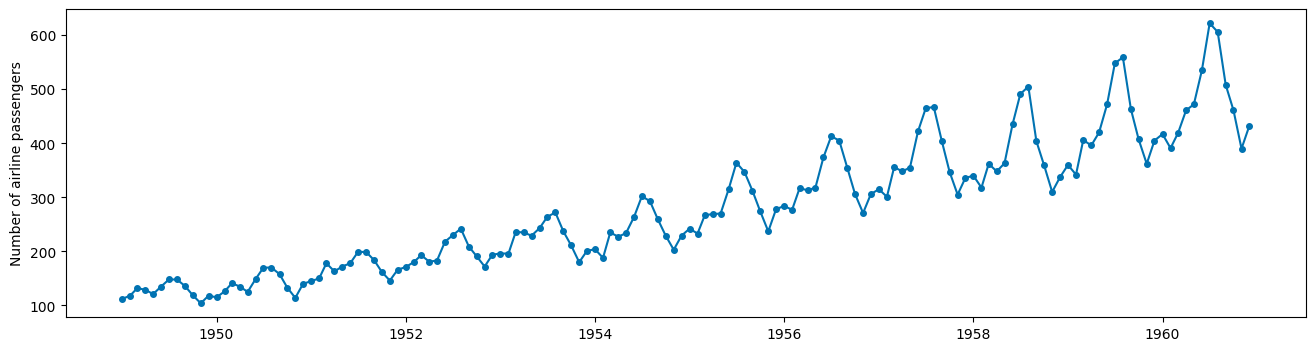

In [33]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y)

The classical way uses autocorrelation plots.

Manual approach using `statsmodels` or `sktime` (thinly wrapping `statsmodels`):

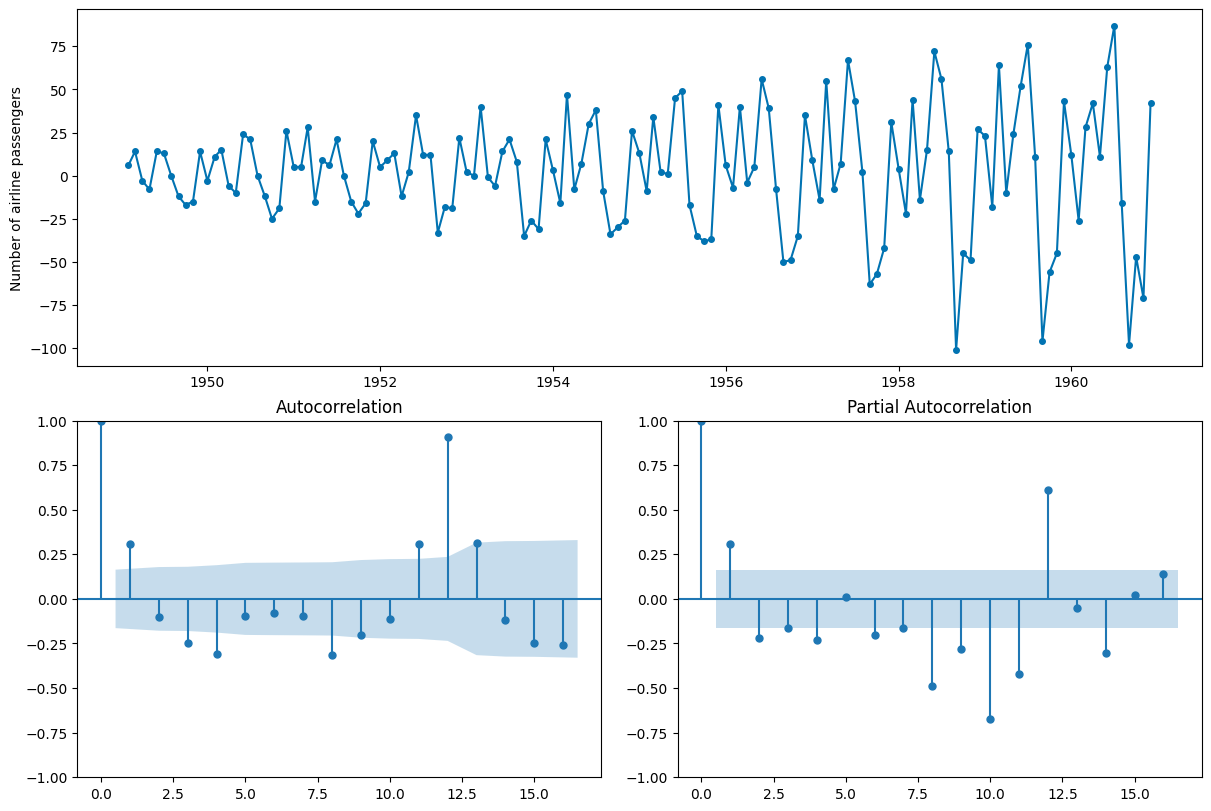

In [34]:
from sktime.utils.plotting import plot_correlations

# acf/pacf on differences to ensure stationarity, there is a visible trend
fig, ax = plot_correlations(y.diff()[1:], lags=16)

`sktime` has a systematic interface for parameter estimators that allows auto-setting of seasonality:

the "parameter estimator" type:

In [35]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

# compute seasonality on first differences
sp_est = Differencer() * SeasonalityACF()

sp_est.fit(y)

ParamFitterPipeline(param_est=SeasonalityACF(), transformers=[Differencer()])

In [36]:
sp_est.get_fitted_params()["sp"]

12

In [37]:
# more stats in here
list(sp_est.get_fitted_params().keys())

['acf',
 'confint',
 'sp',
 'sp_significant',
 'transformers__steps',
 'transformers__Differencer',
 'param_est__acf',
 'param_est__confint',
 'param_est__sp',
 'param_est__sp_significant']

using pipelining, we can plug in the fitted `sp` parameter into any estimator!

In [38]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.param_est.plugin import PluginParamsForecaster

fcst = NaiveForecaster()
sp_auto = PluginParamsForecaster(sp_est, fcst)
sp_auto.fit(y, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

PluginParamsForecaster(forecaster=NaiveForecaster(),
                       param_est=ParamFitterPipeline(param_est=SeasonalityACF(),
                                                     transformers=[Differencer()]))

In [39]:
sp_auto.forecaster_.get_params()["sp"]

12

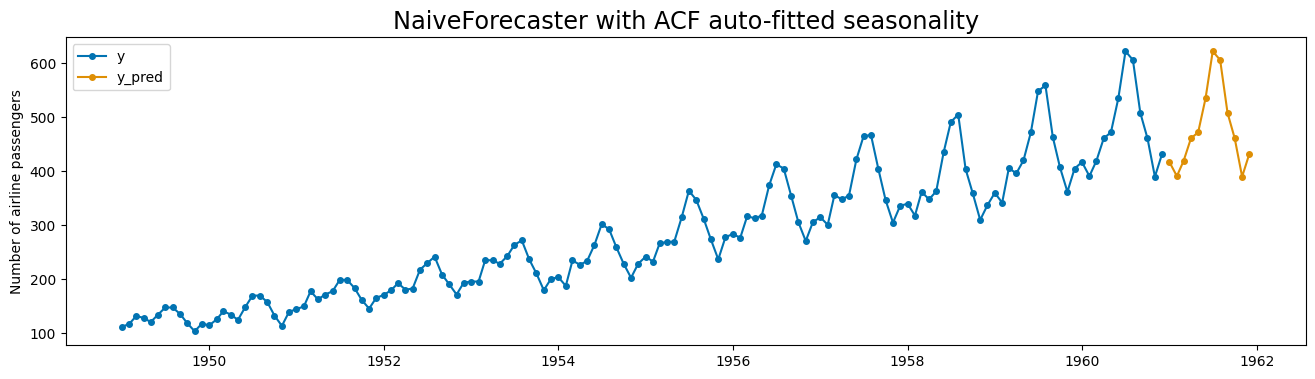

In [40]:
y_pred = sp_auto.predict()

title = f"NaiveForecaster with ACF auto-fitted seasonality"
fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], title=title
)

also useful: conditional transformer

e.g., "test for seasonality, and deseasonalize, but only if there is seasonality"

In [41]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.compose import TransformIf
from sktime.transformations.series.detrend import Deseasonalizer

seasonal = SeasonalityACF(candidate_sp=12)
deseason = Deseasonalizer(sp=12)
cond_deseason = TransformIf(seasonal, "sp", "!=", 1, deseason)
# if seasonality is significant at sp=12, then deseasonalize at sp=12

y_hat = cond_deseason.fit_transform(y)

this can be pipelined with a forecaster:

In [42]:
forecaster_with_cond_deaseason = cond_deseason * NaiveForecaster()

also useful: stationarity tester `StationarityADF` (Dickey-Fuller) - combine with `Differencer`!

### B -  Tuning using grid or random search

Grid/parameter tuning has same syntax as in `sklearn`:

* `get_params` strings and `dict` to set parameter grid/range
* `cv` splitter to define evaluation modus

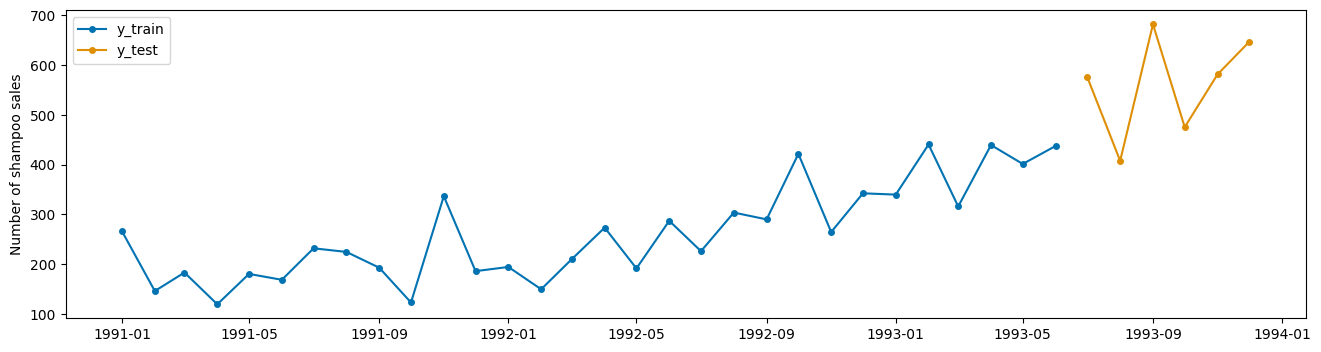

In [43]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

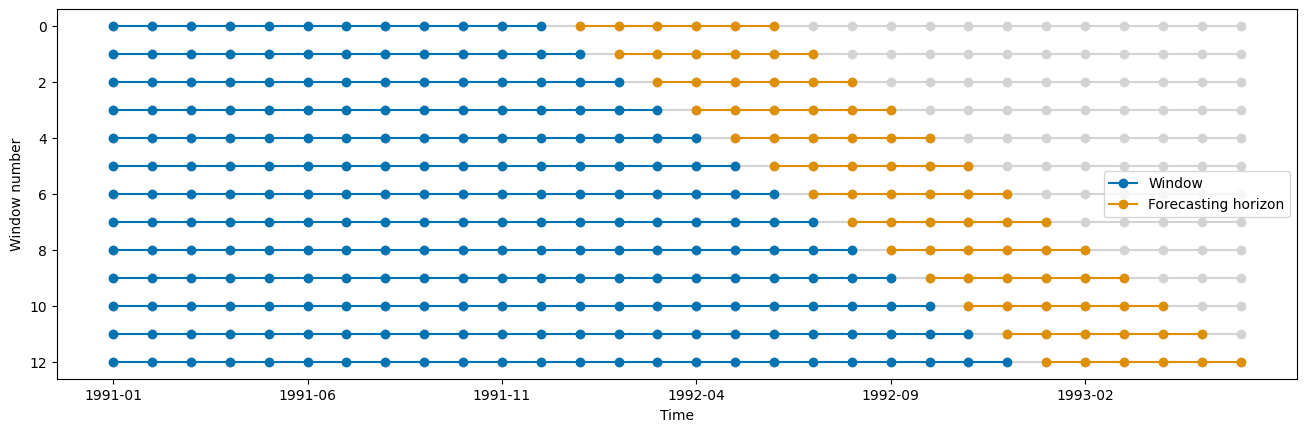

In [44]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(fh=[1,2,3,4,5,6], initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [45]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError

forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 6, 12],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)

In [46]:
gscv.fit(y_train)
fh = [1, 2, 3, 4, 5, 6]
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 24 candidates, totalling 312 fits


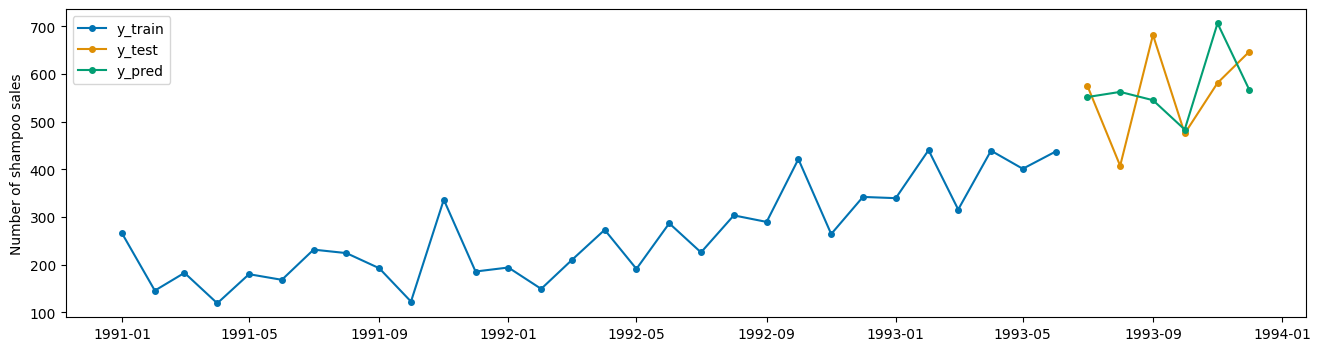

In [47]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [48]:
gscv.best_params_

{'damped_trend': True, 'seasonal': 'add', 'sp': 12, 'trend': 'mul'}

In [49]:
# all fitted parameters also accessible via get_fitted_params
# this can be used in parameter plugin etc
gscv.get_fitted_params()["best_params"]

{'damped_trend': True, 'seasonal': 'add', 'sp': 12, 'trend': 'mul'}

In [50]:
gscv.best_forecaster_

ExponentialSmoothing(damped_trend=True, seasonal='add', sp=12, trend='mul')

for pipelines and composites, parameter names are `[componentname]__[paramname]`:

In [51]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 13 folds for each of 192 candidates, totalling 2496 fits


when using dunders - and in general - paramater names can be inspected using `get_params`

In [52]:
forecaster = \
    Detrender() \
    * Deseasonalizer() \
    * MinMaxScaler((1, 10)) \
    * PowerTransformer() \
    * RobustScaler() \
    * ExponentialSmoothing()

In [53]:
forecaster

TransformedTargetForecaster(steps=[Detrender(), Deseasonalizer(),
                                   TabularToSeriesAdaptor(transformer=MinMaxScaler(feature_range=(1, 10))),
                                   TabularToSeriesAdaptor(transformer=PowerTransformer()),
                                   TabularToSeriesAdaptor(transformer=RobustScaler()),
                                   ExponentialSmoothing()])

In [54]:
forecaster.get_params()

{'steps': [Detrender(),
  Deseasonalizer(),
  TabularToSeriesAdaptor(transformer=MinMaxScaler(feature_range=(1, 10))),
  TabularToSeriesAdaptor(transformer=PowerTransformer()),
  TabularToSeriesAdaptor(transformer=RobustScaler()),
  ExponentialSmoothing()],
 'Detrender': Detrender(),
 'Deseasonalizer': Deseasonalizer(),
 'TabularToSeriesAdaptor_1': TabularToSeriesAdaptor(transformer=MinMaxScaler(feature_range=(1, 10))),
 'TabularToSeriesAdaptor_2': TabularToSeriesAdaptor(transformer=PowerTransformer()),
 'TabularToSeriesAdaptor_3': TabularToSeriesAdaptor(transformer=RobustScaler()),
 'ExponentialSmoothing': ExponentialSmoothing(),
 'Detrender__forecaster': None,
 'Detrender__model': 'additive',
 'Deseasonalizer__model': 'additive',
 'Deseasonalizer__sp': 1,
 'TabularToSeriesAdaptor_1__fit_in_transform': False,
 'TabularToSeriesAdaptor_1__input_type': 'numpy',
 'TabularToSeriesAdaptor_1__pass_y': 'auto',
 'TabularToSeriesAdaptor_1__pooling': 'local',
 'TabularToSeriesAdaptor_1__transfor

### C - Full AutoML

Let's begin by loading the data for which to do AutoML on and split into train and test.

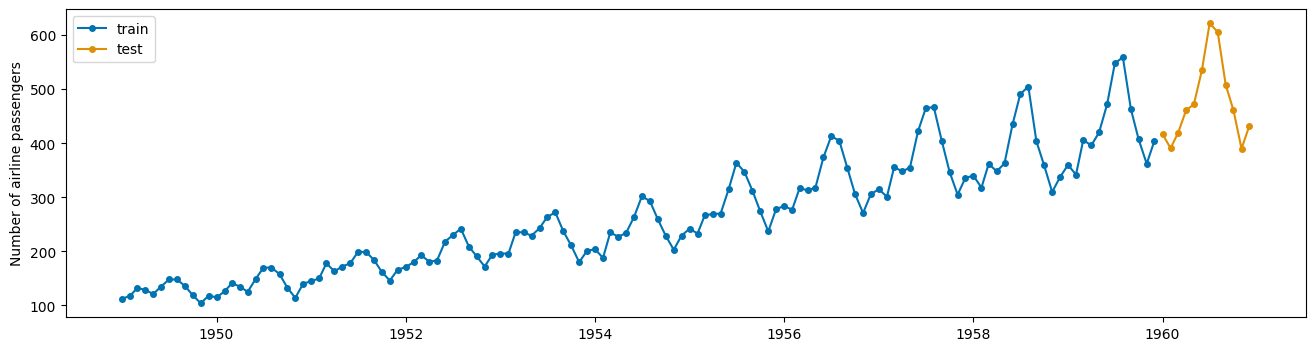

In [55]:
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.datasets import load_airline

y = load_airline()

y_train, y_test = temporal_train_test_split(y=y, test_size=12)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

Now we define the sklearn tree-based regressor and create a forecaster from it using `make_reduction`.

In [56]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12)

In this step we create a pipeline with the all the different steps we wish to try out.

In [57]:
from sklearn.preprocessing import RobustScaler

from sktime.transformations.compose import OptionalPassthrough
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Detrender, Deseasonalizer

forecasting_pipeline = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("differencer", OptionalPassthrough(Differencer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", forecaster),
    ]
)

We would now need to define the parameter grid for the grid search. 

To see what are the available options we can inspect the parameters of the pipeline object.

In [58]:
forecasting_pipeline.get_params()

{'steps': [('detrender', OptionalPassthrough(transformer=Detrender())),
  ('deseasonalizer', OptionalPassthrough(transformer=Deseasonalizer())),
  ('differencer', OptionalPassthrough(transformer=Differencer())),
  ('scaler',
   OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
  ('forecaster',
   DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                     window_length=12))],
 'detrender': OptionalPassthrough(transformer=Detrender()),
 'deseasonalizer': OptionalPassthrough(transformer=Deseasonalizer()),
 'differencer': OptionalPassthrough(transformer=Differencer()),
 'scaler': OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler())),
 'forecaster': DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                   window_length=12),
 'detrender__passthrough': False,
 'detrender__transformer': Detrender(),
 'detrender__transfor

In [59]:
param_grid = {
    "detrender__passthrough": [True, False],
    "deseasonalizer__passthrough": [True, False],
    "differencer__passthrough": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__window_length": [6, 12, 18],
    "forecaster__estimator__learning_rate": [0.1, 0.2], # Note we can also access the regressor parameters
}

Now let's set up the cross validation strategy

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

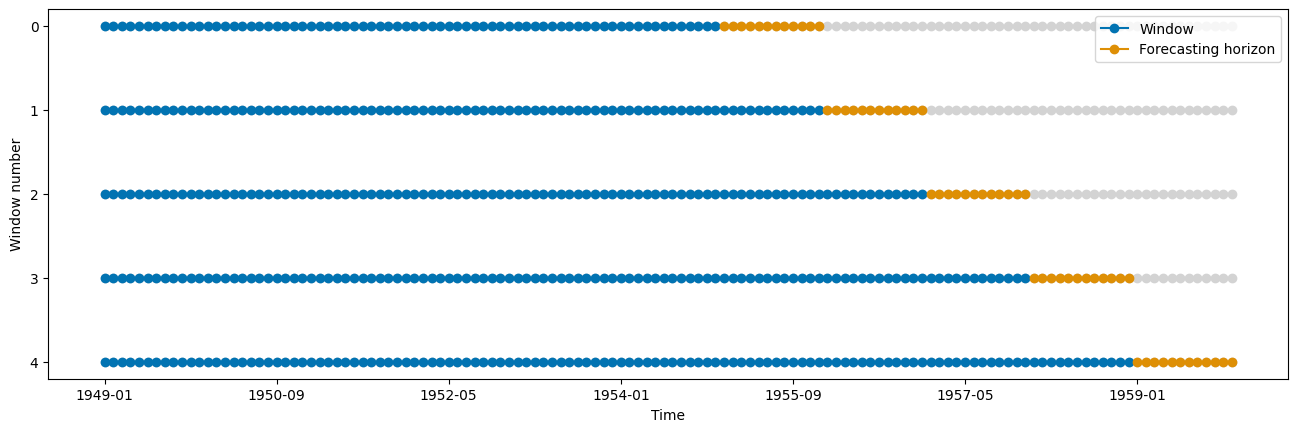

In [60]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

fh = list(range(1, 13))
cv = ExpandingWindowSplitter(initial_window=12*6, fh=fh, step_length=len(fh))
n_folds = cv.get_n_splits(y_train)
plot_windows(cv, y_train)

In [61]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

gscv = ForecastingGridSearchCV(
    forecaster=forecasting_pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=smape,
    error_score="raise",
)

gscv.fit(y=y_train, fh=fh)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12],
                                                   initial_window=72,
                                                   step_length=12),
                        error_score='raise',
                        forecaster=TransformedTargetForecaster(steps=[('detrender',
                                                                       OptionalPassthrough(transformer=Detrender())),
                                                                      ('deseasonalizer',
                                                                       OptionalPassthrough(transformer=Deseasonalizer())),
                                                                      ('differencer',
                                                                       OptionalPassthrough(tran...
                                                                       DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                                                                                         window_length=12))]),
                        n_jobs=-1,
                        param_grid={'deseasonalizer__passthrough': [True,
                                                                    False],
                                    'detrender__passthrough': [True, False],
                                    'differencer__passthrough': [True, False],
                                    'forecaster__estimator__learning_rate': [0.1,
                                                                             0.2],
                                    'forecaster__window_length': [6, 12, 18],
                                    'scaler__passthrough': [True, False]},
                        scoring=MeanAbsolutePercentageError(symmetric=True),
                        verbose=1)

We can now inspect the grid search object to see which was the best model and why.

In [62]:
gscv.best_forecaster_

TransformedTargetForecaster(steps=[('detrender',
                                    OptionalPassthrough(transformer=Detrender())),
                                   ('deseasonalizer',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=Deseasonalizer())),
                                   ('differencer',
                                    OptionalPassthrough(transformer=Differencer())),
                                   ('scaler',
                                    OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
                                   ('forecaster',
                                    DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(learning_rate=0.2),
                                                                      window_length=6))])

In [63]:
gscv.cv_results_.sort_values(by=f"rank_test_MeanAbsolutePercentageError")

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
43,0.067779,0.826818,0.064279,"{'deseasonalizer__passthrough': True, 'detrend...",1.5
91,0.067779,0.843953,0.062163,"{'deseasonalizer__passthrough': False, 'detren...",1.5
42,0.067779,0.763895,0.058468,"{'deseasonalizer__passthrough': True, 'detrend...",3.5
90,0.067779,0.982682,0.070520,"{'deseasonalizer__passthrough': False, 'detren...",3.5
18,0.069984,0.757609,0.055974,"{'deseasonalizer__passthrough': True, 'detrend...",5.5
...,...,...,...,...,...
48,0.196330,0.785086,0.052210,"{'deseasonalizer__passthrough': False, 'detren...",91.5
7,0.197435,0.849340,0.052751,"{'deseasonalizer__passthrough': True, 'detrend...",93.5
55,0.197435,0.826800,0.055775,"{'deseasonalizer__passthrough': False, 'detren...",93.5
6,0.197435,0.781848,0.052192,"{'deseasonalizer__passthrough': True, 'detrend...",95.5


Finally we can use the best performing forecaster in the backtests to make predictions.

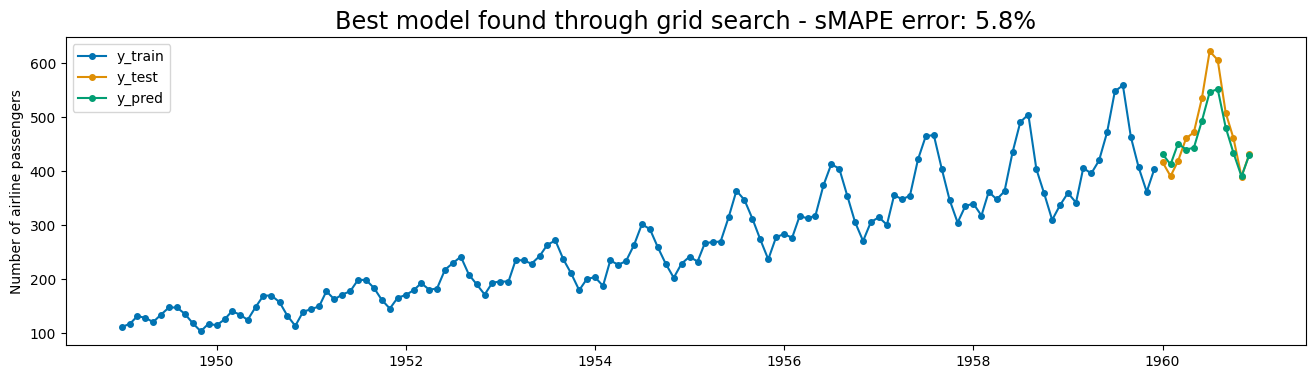

In [64]:
y_pred = gscv.predict(fh=fh)
title = f"Best model found through grid search - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title)

## Summary

* transformers = data processing steps with unified interface - `fit`, `transform`

    * used as pipeline components for any learning task, forecasting, classification

    * different types by input/output - time series, primitives, pairs of time series, panels/hierarchical.

    * rich composition syntax - `*` for pipe, `+` for featureunion, `[in, out]` for variable subset, `|` for multiplex, `-` for switch

* tuning & autoML = auto-setting parameters based on data

    * parameter estimators for specific parameters, e.g., seasonality, stationarity

    * tune any param by grid/random search tuning by backtest `evaluate`

    * autoML = model structure tuning: use `|` multiplex or `-` switch

---

### Credits: notebook - feature engineering, pipelines, tuning, autoML

notebook creation: marrov, fkiraly

in parts based on pydata global 2022 (miraep8, fkiraly, aiwalter, benheid and others)

transformer pipelines & compositors: fkiraly, mloning, miraep8\
forecaster pipelines: fkiraly, aiwalter\
classifier/regressor pipelines: fkiraly\
transformer base interface: mloning, fkiraly\
parameter estimatoras: fkiraly\
dunder interface: fkiraly, miraep8

tuning, autoML: mloning, fkiraly, aiwalter\
CV and splitters: mloning, kkoralturk, khrapovs\
forecasting metrics: mloning, aiwalter, rnkuhns, fkiraly\
backtesting, evaluation: aiwalter, mloning, fkiraly, topher-lo

Based on design ideas: sklearn, magrittr, mlr, mlj